In [1]:
### File Organization ###
# Imports
# RNN models classes
    # Simple RNN
    # Groovy (5 layer GRU model)
    # Loovy (5 layer LSTM model)
    # Super Groovy (8 layer GRU model)
    # Super Loovy (8 layer LSTM model)
# Graph plotting method
# Data prep - get data from fastquant
# Data prep - helper methods and variables
# Data prep, train, predict methods
# Training/Predict Models
    # Simple RNN Apple - High column only
    # Groovy Apple - High column only
    # Loovy Apple - High column only
    # Super Groovy Apple - High column only
    # Super Loovy Apple - High column only
    # Simple RNN IBM - High column only
    # Groovy IBM - High column only
    # Loovy IBM - High column only
    # Super Groovy IBM - High column only
    # Super Loovy IBM - High column only

In [2]:
from fastquant import get_stock_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [3]:
# Build SimpleRNN Model

# 3 SimpleRNN layers with 32 inputs. Returns full sequence.
# 1 SimpleRNN layer with 32 inputs. Does not return full sequence
# 1 Dense layer with 1 input. 
# input -> 32 -> 32 -> 32 -> 32noFS -> 1
# Activation: elu
# Kernel Initializer: Glorot Uniform
# Recurrent Initializer: Orthogonal
# Bias Initializer: Zeross
# Optimizer = RMSProp

sr_learning_rate = 0.001
sr_momentum = 0.9
sr_optimizer = RMSprop(learning_rate=sr_learning_rate)
sr_loss = 'mean_absolute_percentage_error'
sr_activation_funct = 'elu'
sr_epochs = 100
sr_batch_size = 150
sr_dropout = 0.2

# Builds a new instance of Simple RNN and scaler (if needed)
def build_simple_rnn(useDropout = True):
    # scaler = MinMaxScaler(feature_range=(0,1))
    scaler = StandardScaler()

    model = Sequential()
    model.add(SimpleRNN(32, return_sequences=True, activation=sr_activation_funct))
    if useDropout: model.add(Dropout(sr_dropout))
    model.add(SimpleRNN(32, return_sequences=True, activation=sr_activation_funct))
    if useDropout: model.add(Dropout(sr_dropout))
    model.add(SimpleRNN(32, return_sequences=True, activation=sr_activation_funct))
    if useDropout: model.add(Dropout(sr_dropout))
    model.add(SimpleRNN(32, return_sequences=False, activation=sr_activation_funct))
    model.add(Dense(1, activation=sr_activation_funct))

    model.compile(optimizer=sr_optimizer, loss=sr_loss)

    return model, scaler

In [4]:
# Build Groovy Model

# 3 GRU layers with 50 inputs. Returns full sequence
# 1 GRU layer with 50 inputs. Does not return full sequence
# 1 Dense layer with 1 input.
# input -> 50 -> 50 -> 50 -> 50noFS ->1
# Activation: elu
# Kernel Initializer: Glorot Uniform
# Recurrent Initializer: Orthogonal
# Bias Initializer: Zeros
# Optimizer = RMSProp

# Hyperparameters
g_learning_rate = 0.001
g_momentum = 0.9
g_optimizer = RMSprop(learning_rate=g_learning_rate)
g_loss = 'mean_absolute_percentage_error'
g_activation_funct = 'elu'
g_epochs = 100
g_batch_size = 150
g_dropout = 0.2

def build_groovy(useDropout = True):
    scaler = MinMaxScaler(feature_range=(0,1))
    # scaler = StandardScaler()

    model = Sequential()
    model.add(GRU(50, return_sequences=True, activation=g_activation_funct))
    if useDropout: model.add(Dropout(g_dropout))
    model.add(GRU(50, return_sequences=True, activation=g_activation_funct))
    if useDropout: model.add(Dropout(g_dropout))
    model.add(GRU(50, return_sequences=True, activation=g_activation_funct))
    if useDropout: model.add(Dropout(g_dropout))
    model.add(GRU(50, return_sequences=False, activation=g_activation_funct))
    model.add(Dense(1, activation=g_activation_funct))

    model.compile(optimizer=g_optimizer, loss=g_loss)

    return model, scaler

In [5]:
# Build Loovy Model

# 3 LSTM layers with 50 inputs. Returns full sequence
# 1 LSTM layer with 50 inputs. Does not return full sequence
# 1 Dense layer with 1 input.
# input -> 50 -> 50 -> 50 -> 50noFS ->1
# Activation: elu
# Kernel Initializer: Glorot Uniform
# Recurrent Initializer: Orthogonal
# Bias Initializer: Zeros
# Optimizer = RMSProp

# Hyperparameters
l_learning_rate = 0.001
l_momentum = 0.9
l_optimizer = RMSprop(learning_rate=l_learning_rate)
l_loss = 'mean_absolute_percentage_error'
l_activation_funct = 'elu'
l_epochs = 100
l_batch_size = 150
l_dropout = 0.2

def build_loovy(useDropout = True):
    scaler = MinMaxScaler(feature_range=(0,1))
    # scaler = StandardScaler()

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, activation=l_activation_funct))
    if useDropout: model.add(Dropout(l_dropout))
    model.add(LSTM(50, return_sequences=True, activation=l_activation_funct))
    if useDropout: model.add(Dropout(l_dropout))
    model.add(LSTM(50, return_sequences=True, activation=l_activation_funct))
    if useDropout: model.add(Dropout(l_dropout))
    model.add(LSTM(50, return_sequences=False, activation=l_activation_funct))
    model.add(Dense(1, activation=l_activation_funct))

    model.compile(optimizer=l_optimizer, loss=l_loss)

    return model, scaler

In [6]:
# Build SuperGroovy Model

# 6 GRU layers with 50 inputs. Returns full sequence
# 1 GRU layer with 50 inputs. Does not return full sequence
# 1 Dense layer with 1 input.
# input -> 50 -> 50 -> 50 -> 50noFS ->1
# Activation: elu
# Kernel Initializer: Glorot Uniform
# Recurrent Initializer: Orthogonal
# Bias Initializer: Zeros
# Optimizer = RMSProp

# Hyperparameters
sg_learning_rate = 0.001
sg_momentum = 0.9
sg_optimizer = RMSprop(learning_rate=sg_learning_rate)
sg_loss = 'mean_absolute_percentage_error'
sg_activation_funct = 'elu'
sg_epochs = 100
sg_batch_size = 150
sg_dropout = 0.2

def build_super_groovy(useDropout = True):
    scaler = MinMaxScaler(feature_range=(0,1))
    # scaler = StandardScaler()

    model = Sequential()
    model.add(GRU(50, return_sequences=True, activation=sg_activation_funct))
    if useDropout: model.add(Dropout(sg_dropout))
    model.add(GRU(50, return_sequences=True, activation=sg_activation_funct))
    if useDropout: model.add(Dropout(sg_dropout))
    model.add(GRU(50, return_sequences=True, activation=sg_activation_funct))
    if useDropout: model.add(Dropout(sg_dropout))
    model.add(GRU(50, return_sequences=True, activation=sg_activation_funct))
    if useDropout: model.add(Dropout(sg_dropout))
    model.add(GRU(50, return_sequences=True, activation=sg_activation_funct))
    if useDropout: model.add(Dropout(sg_dropout))
    model.add(GRU(50, return_sequences=True, activation=sg_activation_funct))
    if useDropout: model.add(Dropout(sg_dropout))
    model.add(GRU(50, return_sequences=False, activation=sg_activation_funct))
    model.add(Dense(1, activation=sg_activation_funct))

    model.compile(optimizer=sg_optimizer, loss=sg_loss)

    return model, scaler

In [7]:
# Build SuperLoovy Model

# 6 LSTM layers with 50 inputs. Returns full sequence
# 1 LSTM layer with 50 inputs. Does not return full sequence
# 1 Dense layer with 1 input.
# input -> 50 -> 50 -> 50 -> 50noFS ->1
# Activation: elu
# Kernel Initializer: Glorot Uniform
# Recurrent Initializer: Orthogonal
# Bias Initializer: Zeros
# Optimizer = RMSProp

# Hyperparameters
sl_learning_rate = 0.001
sl_momentum = 0.9
sl_optimizer = RMSprop(learning_rate=sl_learning_rate)
sl_loss = 'mean_absolute_percentage_error'
sl_activation_funct = 'elu'
sl_epochs = 100
sl_batch_size = 150
sl_dropout = 0.2

def build_super_loovy(useDropout = True):
    scaler = MinMaxScaler(feature_range=(0,1))
    # scaler = StandardScaler()

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, activation=sl_activation_funct))
    if useDropout: model.add(Dropout(sl_dropout))
    model.add(LSTM(50, return_sequences=True, activation=sl_activation_funct))
    if useDropout: model.add(Dropout(sl_dropout))
    model.add(LSTM(50, return_sequences=True, activation=sl_activation_funct))
    if useDropout: model.add(Dropout(sl_dropout))
    model.add(LSTM(50, return_sequences=True, activation=sl_activation_funct))
    if useDropout: model.add(Dropout(sl_dropout))
    model.add(LSTM(50, return_sequences=True, activation=sl_activation_funct))
    if useDropout: model.add(Dropout(sl_dropout))
    model.add(LSTM(50, return_sequences=True, activation=sl_activation_funct))
    if useDropout: model.add(Dropout(sl_dropout))
    model.add(LSTM(50, return_sequences=False, activation=sl_activation_funct))
    model.add(Dense(1, activation=sl_activation_funct))

    model.compile(optimizer=sl_optimizer, loss=sl_loss)

    return model, scaler

In [8]:
# Plotting methods
def plot_results(preds, actual, title):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.set_title(title)
    time = range(len(preds))
    ax.plot(time,preds,color='tab:red',marker='s',markersize=2,linestyle='-',linewidth=1,label='forcast')
    ax.plot(time,actual,color='tab:blue',marker='s',markersize=2,linestyle='-',linewidth=1,label='actual')
    ax.set_xlabel('time')
    ax.set_ylabel('stock price ($)')
    ax.set_xticks(np.arange(0,len(preds)+10,10))
    ax.set_xlim(0,len(preds)+10)
    ax.xaxis.grid(True,ls='--')
    ax.yaxis.grid(True,ls='--')
    ax.legend()
    fig.tight_layout()
    plt.savefig(f'../imgs/{title}.png', ext='png', bbox_inches="tight")  

In [9]:
# Data Prep - Get Data

# training with apple feb-10-2003 -> sep-10-2004
full_apple_train = get_stock_data("AAPL","2003-02-10","2004-09-10")
# testing with apple sep-13-2004 -> jan-21-2005
full_apple_test =  get_stock_data("AAPL","2004-09-13","2005-01-21")
# training with IBM feb-10-2003 -> sep-10-2004
full_ibm_train = get_stock_data("IBM","2003-02-10","2004-09-10")
# testing with IBM sep-13-2004 -> jan-21-2005
full_ibm_test =  get_stock_data("IBM","2004-09-13","2005-01-21")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
# Data Prep - Helper Methods/Vars

day_range = 60 # length of days to split data on

# Extract high and normalize high data
def data_prep(train_data, test_data, scaler):
    high_train_data = train_data['high'].values
    high_train_data = high_train_data.reshape(-1,1)
    train_scale = scaler.fit_transform(high_train_data)

    high_test_data = test_data['high'].values
    high_test_data = high_test_data.reshape(-1,1)
    test_scale = scaler.transform(high_test_data)

    return train_scale, test_scale, scaler

# Split train/test data into x/y sets
# For single column i.e. like high only
def get_xy_train_sets(train_data):
    X_train = []
    Y_train = []

    for i in range(day_range, len(train_data)):
        X_train.append(train_data[i-day_range:i, 0])
        Y_train.append(train_data[i,0])

    x_train, y_train = np.array(X_train), np.array(Y_train)
    x_train = np.reshape(x_train, (*x_train.shape, 1))

    return x_train, y_train

def get_xy_test_sets(scaled_test_data, raw_test_data):
    X_test = []
    for i in range(day_range, len(scaled_test_data)):
        X_test.append(scaled_test_data[i-day_range:i, 0])

    x_test = np.array(X_test)
    x_test = np.reshape(x_test, (*x_test.shape, 1))

    high_test_data = raw_test_data['high'].values
    
    Y_test = []
    for i in range(day_range, len(high_test_data)):
        Y_test.append(high_test_data[i])
    
    y_test = np.array(Y_test)

    return x_test, y_test

In [11]:
# Data prep, train, predict methods

def prepare_train_data(full_train_data, full_test_data, scaler):
    return data_prep(full_train_data, full_test_data, scaler)

def get_train_data(scaled_train):
    return get_xy_train_sets(scaled_train)

def get_test_data(scaled_test, full_test_data):
    return get_xy_test_sets(scaled_test, full_test_data)

def train(model, in_epochs, in_batch_size):
    model.fit(x_train, y_train, epochs=in_epochs, batch_size=in_batch_size)
    return model

def predict(model, x_test, scaler):
    scaled_predictions = model.predict(x_test)
    test_predictions = scaler.inverse_transform(scaled_predictions)
    return test_predictions

Starting Simple RNN MAPE - Apple using High
Epoch 1/100
339/339 [==============================] - 1s 3ms/step - loss: 1337.2246
Epoch 2/100
339/339 [==============================] - 0s 607us/step - loss: 1845.9411
Epoch 3/100
339/339 [==============================] - 0s 645us/step - loss: 1139.2685
Epoch 4/100
339/339 [==============================] - 0s 604us/step - loss: 1446.2860
Epoch 5/100
339/339 [==============================] - 0s 548us/step - loss: 658.8036
Epoch 6/100
339/339 [==============================] - 0s 533us/step - loss: 892.5782
Epoch 7/100
339/339 [==============================] - 0s 530us/step - loss: 1204.4736
Epoch 8/100
339/339 [==============================] - 0s 519us/step - loss: 1188.0753
Epoch 9/100
339/339 [==============================] - 0s 525us/step - loss: 1066.4526
Epoch 10/100
339/339 [==============================] - 0s 523us/step - loss: 1017.2023
Epoch 11/100
339/339 [==============================] - 0s 510us/step - loss: 802.0968
Ep

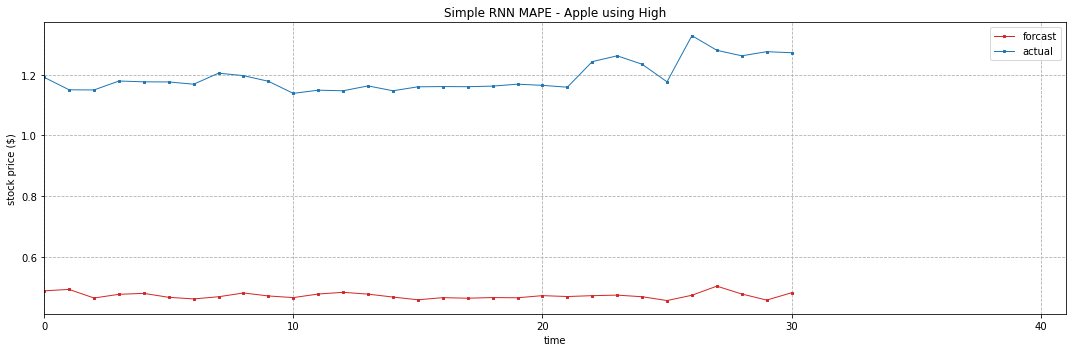

In [12]:
# Apple
print('Starting Simple RNN MAPE - Apple using High')
rnn, scaler = build_simple_rnn()

train_scale, test_scale, scaler = prepare_train_data(full_apple_train, full_apple_test, scaler)
x_train, y_train = get_train_data(train_scale)
x_test, y_test = get_test_data(test_scale, full_apple_test)

rnn = train(rnn, sr_epochs, sr_batch_size)
y_preds = predict(rnn, x_test, scaler)

plot_results(y_preds, y_test, 'Simple RNN MAPE - Apple using High')

Starting Groovy RNN MAPE - Apple using High
Epoch 1/100
339/339 [==============================] - 2s 7ms/step - loss: 66.4048
Epoch 2/100
339/339 [==============================] - 1s 2ms/step - loss: 28.3593
Epoch 3/100
339/339 [==============================] - 1s 2ms/step - loss: 19.9029
Epoch 4/100
339/339 [==============================] - 1s 2ms/step - loss: 21.4683
Epoch 5/100
339/339 [==============================] - 1s 2ms/step - loss: 17.1424
Epoch 6/100
339/339 [==============================] - 1s 2ms/step - loss: 20.6671
Epoch 7/100
339/339 [==============================] - 1s 2ms/step - loss: 16.7105
Epoch 8/100
339/339 [==============================] - 1s 2ms/step - loss: 14.8050
Epoch 9/100
339/339 [==============================] - 1s 2ms/step - loss: 18.9614
Epoch 10/100
339/339 [==============================] - 1s 2ms/step - loss: 18.9228
Epoch 11/100
339/339 [==============================] - 1s 2ms/step - loss: 15.9454
Epoch 12/100
339/339 [===================

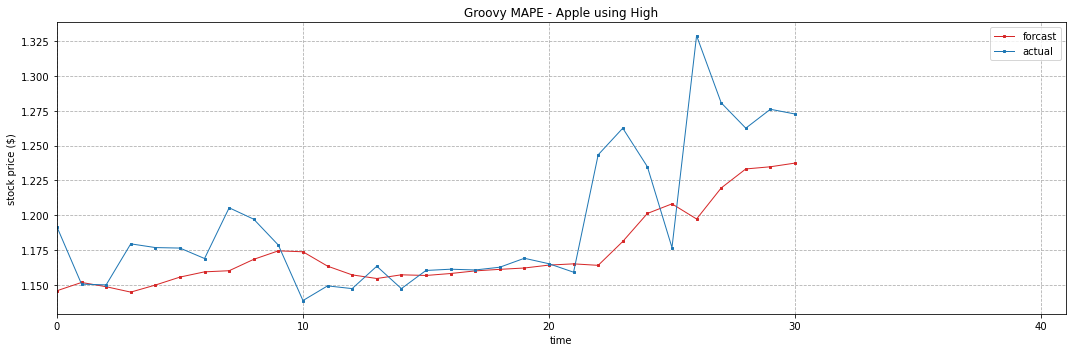

In [14]:
# Apple
print('Starting Groovy RNN MAPE - Apple using High')
rnn, scaler = build_groovy()

train_scale, test_scale, scaler = prepare_train_data(full_apple_train, full_apple_test, scaler)
x_train, y_train = get_train_data(train_scale)
x_test, y_test = get_test_data(test_scale, full_apple_test)

rnn = train(rnn, g_epochs, g_batch_size)
y_preds = predict(rnn, x_test, scaler)

plot_results(y_preds, y_test, 'Groovy MAPE - Apple using High')

Starting Loovy RNN MAPE - Apple using High
Epoch 1/100
339/339 [==============================] - 2s 6ms/step - loss: 77.1210
Epoch 2/100
339/339 [==============================] - 1s 2ms/step - loss: 43.5589
Epoch 3/100
339/339 [==============================] - 1s 2ms/step - loss: 25.6110
Epoch 4/100
339/339 [==============================] - 1s 2ms/step - loss: 21.7271
Epoch 5/100
339/339 [==============================] - 1s 2ms/step - loss: 22.8128
Epoch 6/100
339/339 [==============================] - 1s 2ms/step - loss: 19.8135
Epoch 7/100
339/339 [==============================] - 1s 2ms/step - loss: 21.6895
Epoch 8/100
339/339 [==============================] - 1s 2ms/step - loss: 20.7708
Epoch 9/100
339/339 [==============================] - 1s 2ms/step - loss: 21.0528
Epoch 10/100
339/339 [==============================] - 1s 2ms/step - loss: 19.1443
Epoch 11/100
339/339 [==============================] - 1s 2ms/step - loss: 21.3611
Epoch 12/100
339/339 [====================

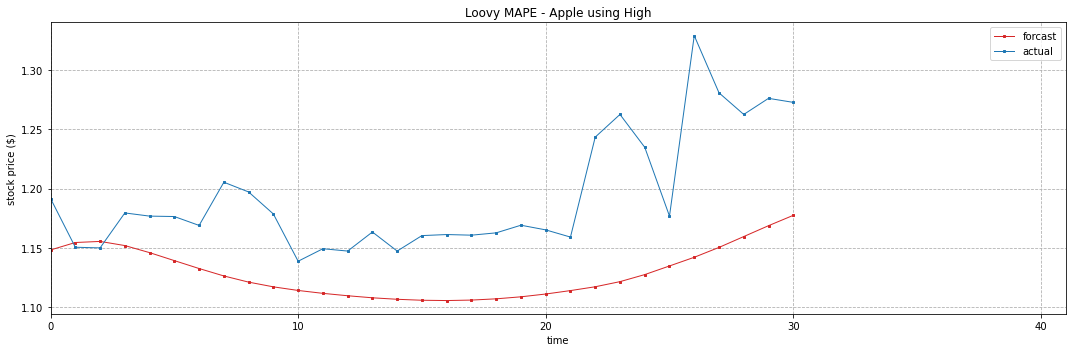

In [15]:
# Apple
print('Starting Loovy RNN MAPE - Apple using High')
rnn, scaler = build_loovy()

train_scale, test_scale, scaler = prepare_train_data(full_apple_train, full_apple_test, scaler)
x_train, y_train = get_train_data(train_scale)
x_test, y_test = get_test_data(test_scale, full_apple_test)

rnn = train(rnn, l_epochs, l_batch_size)
y_preds = predict(rnn, x_test, scaler)

plot_results(y_preds, y_test, 'Loovy MAPE - Apple using High')

Starting Super Groovy RNN MAPE - Apple using High
Epoch 1/100
339/339 [==============================] - 4s 12ms/step - loss: 74.5662
Epoch 2/100
339/339 [==============================] - 1s 4ms/step - loss: 26.0744
Epoch 3/100
339/339 [==============================] - 1s 4ms/step - loss: 21.8152
Epoch 4/100
339/339 [==============================] - 1s 4ms/step - loss: 25.5781
Epoch 5/100
339/339 [==============================] - 2s 4ms/step - loss: 21.9275
Epoch 6/100
339/339 [==============================] - 1s 4ms/step - loss: 24.6317
Epoch 7/100
339/339 [==============================] - 1s 4ms/step - loss: 20.7514
Epoch 8/100
339/339 [==============================] - 1s 4ms/step - loss: 23.5778
Epoch 9/100
339/339 [==============================] - 1s 4ms/step - loss: 20.7716
Epoch 10/100
339/339 [==============================] - 1s 4ms/step - loss: 22.2048
Epoch 11/100
339/339 [==============================] - 1s 4ms/step - loss: 26.8718
Epoch 12/100
339/339 [============

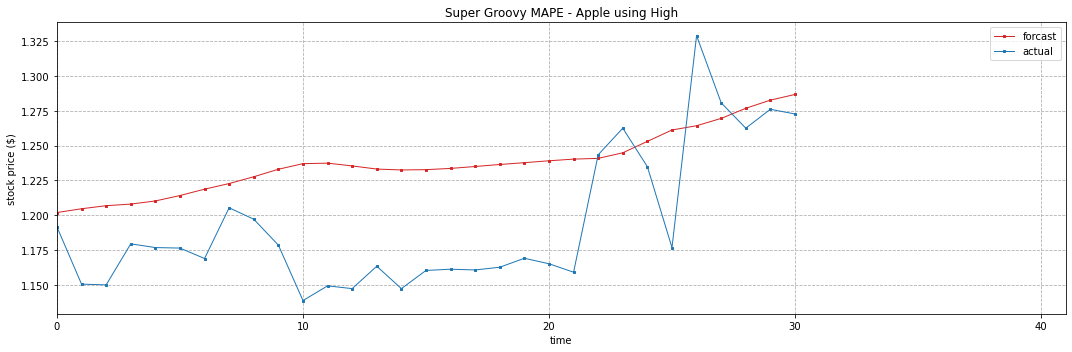

In [16]:
# Apple
print('Starting Super Groovy RNN MAPE - Apple using High')
rnn, scaler = build_super_groovy()

train_scale, test_scale, scaler = prepare_train_data(full_apple_train, full_apple_test, scaler)
x_train, y_train = get_train_data(train_scale)
x_test, y_test = get_test_data(test_scale, full_apple_test)

rnn = train(rnn, sg_epochs, sg_batch_size)
y_preds = predict(rnn, x_test, scaler)

plot_results(y_preds, y_test, 'Super Groovy MAPE - Apple using High')

Starting Super Loovy RNN MAPE - Apple using High
Epoch 1/100
339/339 [==============================] - 4s 11ms/step - loss: 89.0753
Epoch 2/100
339/339 [==============================] - 1s 4ms/step - loss: 42.4198
Epoch 3/100
339/339 [==============================] - 1s 4ms/step - loss: 23.3084
Epoch 4/100
339/339 [==============================] - 1s 4ms/step - loss: 24.4046
Epoch 5/100
339/339 [==============================] - 1s 4ms/step - loss: 26.9814
Epoch 6/100
339/339 [==============================] - 1s 4ms/step - loss: 25.6036
Epoch 7/100
339/339 [==============================] - 1s 4ms/step - loss: 23.2277
Epoch 8/100
339/339 [==============================] - 1s 4ms/step - loss: 27.0156
Epoch 9/100
339/339 [==============================] - 1s 4ms/step - loss: 25.8452
Epoch 10/100
339/339 [==============================] - 1s 4ms/step - loss: 20.1103
Epoch 11/100
339/339 [==============================] - 1s 4ms/step - loss: 27.2256
Epoch 12/100
339/339 [=============

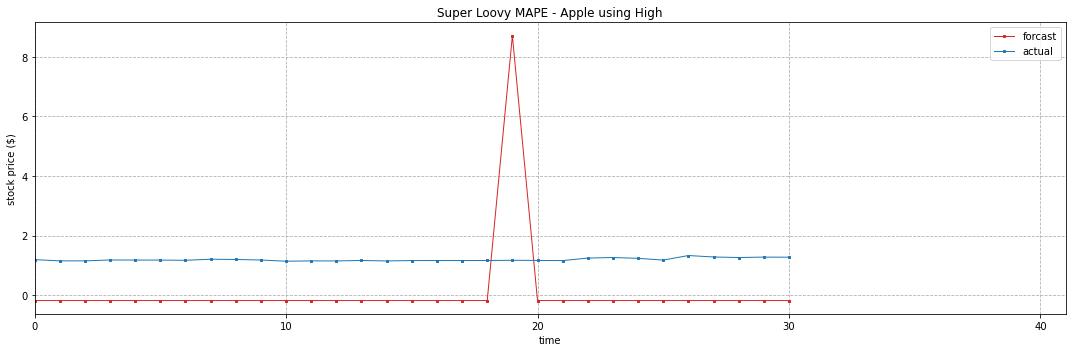

In [17]:
# Apple
print('Starting Super Loovy RNN MAPE - Apple using High')
rnn, scaler = build_super_loovy()

train_scale, test_scale, scaler = prepare_train_data(full_apple_train, full_apple_test, scaler)
x_train, y_train = get_train_data(train_scale)
x_test, y_test = get_test_data(test_scale, full_apple_test)

rnn = train(rnn, sl_epochs, sl_batch_size)
y_preds = predict(rnn, x_test, scaler)

plot_results(y_preds, y_test, 'Super Loovy MAPE - Apple using High')

Starting Simple RNN MAPE - IBM using High
Epoch 1/100
339/339 [==============================] - 1s 3ms/step - loss: 383.6176
Epoch 2/100
339/339 [==============================] - 0s 555us/step - loss: 278.3564
Epoch 3/100
339/339 [==============================] - 0s 545us/step - loss: 255.0963
Epoch 4/100
339/339 [==============================] - 0s 548us/step - loss: 244.1778
Epoch 5/100
339/339 [==============================] - 0s 535us/step - loss: 246.5736
Epoch 6/100
339/339 [==============================] - 0s 536us/step - loss: 249.4742
Epoch 7/100
339/339 [==============================] - 0s 539us/step - loss: 246.8040
Epoch 8/100
339/339 [==============================] - 0s 536us/step - loss: 225.5093
Epoch 9/100
339/339 [==============================] - 0s 530us/step - loss: 229.2416
Epoch 10/100
339/339 [==============================] - 0s 522us/step - loss: 190.3129
Epoch 11/100
339/339 [==============================] - 0s 528us/step - loss: 206.1669
Epoch 12/100

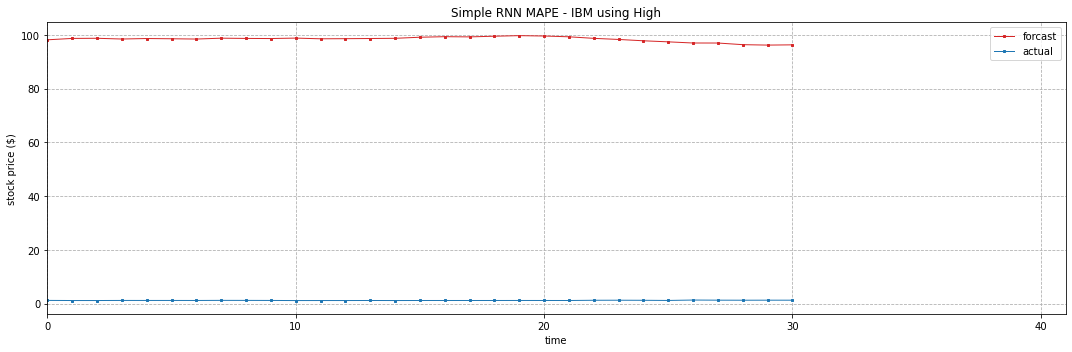

In [18]:
# IBM
print('Starting Simple RNN MAPE - IBM using High')
rnn, scaler = build_simple_rnn()

train_scale, test_scale, scaler = prepare_train_data(full_ibm_train, full_ibm_test, scaler)
x_train, y_train = get_train_data(train_scale)
x_test, y_test = get_test_data(test_scale, full_ibm_test)

rnn = train(rnn, sr_epochs, sr_batch_size)
y_preds = predict(rnn, x_test, scaler)

plot_results(y_preds, y_test, 'Simple RNN MAPE - IBM using High')

In [20]:
# IBM
print('Starting Groovy RNN MAPE - IBM using High')
rnn, scaler = build_groovy()

train_scale, test_scale, scaler = prepare_train_data(full_ibm_train, full_ibm_test, scaler)
x_train, y_train = get_train_data(train_scale)
x_test, y_test = get_test_data(test_scale, full_ibm_test)

rnn = train(rnn, g_epochs, g_batch_size)
y_preds = predict(rnn, x_test, scaler)

plot_results(y_preds, y_test, 'Groovy MAPE - IBM using High')

Starting Groovy RNN MAPE - IBM using High
Epoch 1/100
339/339 [==============================] - 2s 7ms/step - loss: 71.7646
Epoch 2/100
339/339 [==============================] - 1s 2ms/step - loss: 32.0038
Epoch 3/100
339/339 [==============================] - 1s 2ms/step - loss: 16.7328
Epoch 4/100
339/339 [==============================] - 1s 2ms/step - loss: 16.2012
Epoch 5/100
339/339 [==============================] - 1s 2ms/step - loss: 15.4255
Epoch 6/100
339/339 [==============================] - 1s 2ms/step - loss: 25.9369
Epoch 7/100
339/339 [==============================] - 1s 2ms/step - loss: 18.3438
Epoch 8/100
339/339 [==============================] - 1s 2ms/step - loss: 16.6753
Epoch 9/100
339/339 [==============================] - 1s 2ms/step - loss: 18.9956
Epoch 10/100
339/339 [==============================] - 1s 2ms/step - loss: 14.7854
Epoch 11/100
339/339 [==============================] - 1s 2ms/step - loss: 19.6659
Epoch 12/100
339/339 [=====================

KeyboardInterrupt: 

Starting Loovy RNN MAPE - IBM using High
Epoch 1/100
339/339 [==============================] - 2s 6ms/step - loss: 80.5739
Epoch 2/100
339/339 [==============================] - 1s 2ms/step - loss: 33.8727
Epoch 3/100
339/339 [==============================] - 1s 2ms/step - loss: 21.1301
Epoch 4/100
339/339 [==============================] - 1s 2ms/step - loss: 19.7887
Epoch 5/100
339/339 [==============================] - 1s 2ms/step - loss: 26.3187
Epoch 6/100
339/339 [==============================] - 1s 2ms/step - loss: 23.8963
Epoch 7/100
339/339 [==============================] - 1s 2ms/step - loss: 22.5211
Epoch 8/100
339/339 [==============================] - 1s 2ms/step - loss: 22.1415
Epoch 9/100
339/339 [==============================] - 1s 2ms/step - loss: 24.0342
Epoch 10/100
339/339 [==============================] - 1s 2ms/step - loss: 28.3043
Epoch 11/100
339/339 [==============================] - 1s 2ms/step - loss: 21.2945
Epoch 12/100
339/339 [======================

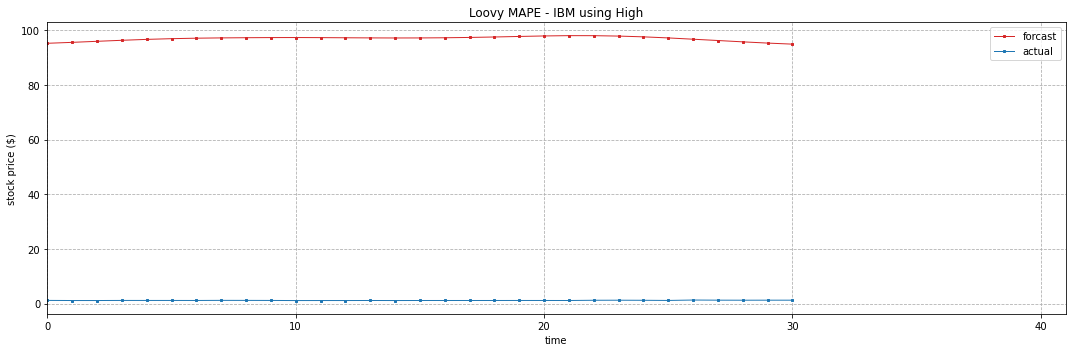

In [19]:
# IBM
print('Starting Loovy RNN MAPE - IBM using High')
rnn, scaler = build_loovy()

train_scale, test_scale, scaler = prepare_train_data(full_ibm_train, full_ibm_test, scaler)
x_train, y_train = get_train_data(train_scale)
x_test, y_test = get_test_data(test_scale, full_ibm_test)

rnn = train(rnn, l_epochs, l_batch_size)
y_preds = predict(rnn, x_test, scaler)

plot_results(y_preds, y_test, 'Loovy MAPE - IBM using High')

In [ ]:
# IBM
print('Starting Super Groovy RNN MAPE - IBM using High')
rnn, scaler = build_super_groovy()

train_scale, test_scale, scaler = prepare_train_data(full_ibm_train, full_ibm_test, scaler)
x_train, y_train = get_train_data(train_scale)
x_test, y_test = get_test_data(test_scale, full_ibm_test)

rnn = train(rnn, sg_epochs, sg_batch_size)
y_preds = predict(rnn, x_test, scaler)

plot_results(y_preds, y_test, 'Super Groovy MAPE - IBM using High')

In [ ]:
# IBM
print('Starting Super Loovy RNN MAPE - IBM using High')
rnn, scaler = build_super_loovy()

train_scale, test_scale, scaler = prepare_train_data(full_ibm_train, full_ibm_test, scaler)
x_train, y_train = get_train_data(train_scale)
x_test, y_test = get_test_data(test_scale, full_ibm_test)

rnn = train(rnn, sl_epochs, sl_batch_size)
y_preds = predict(rnn, x_test, scaler)

plot_results(y_preds, y_test, 'Super Loovy MAPE - IBM using High')